In [1]:
# Отдельная генерация и сохранение train/text массивов для xgbooster  (2017-07-02)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, estimateResult

In [6]:
binsData = 96

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [7]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [9]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [10]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [11]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [12]:
#
# Построение по входным наборам гистограмм и переработанных изображений (изменение размеров, улучшение, сглаживание
#

def formX3 (ni, resize=(32,32), printOK=False, GaussianOK=True, EqualizeOK=False) :
        if GaussianOK : ni = np.array([cv.GaussianBlur(ni[:,:,i],(3,3),0) for i in range(ni.shape[2])]).T;
        if EqualizeOK : ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2])]).T;
        if resize and ((ni.shape[0],ni.shape[1])<>resize) : ni = cv.resize(ni,resize)
        return(ni)
    
def formX4 (ni, resize=(32,32), printOK=False, GaussianOK=True, EqualizeOK=False, OnlyNI=False, ExtIndex=True) :
    
        #before or after???? 
        #Equalize only 256 color!  ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2]-1)]).T;
        
        if GaussianOK : ni = np.array([cv.GaussianBlur(ni[:,:,i],(3,3),0) for i in range(ni.shape[2])]).T;
        r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
        if resize and ((ni.shape[0],ni.shape[1])<>resize) : 
            r,g,b,n = cv.resize(r,resize),cv.resize(g,resize),cv.resize(b,resize),cv.resize(n,resize)
        r,g,b,n = np.array(r,np.float32),np.array(g,np.float32),np.array(b,np.float32),np.array(n,np.float32)
        
        
        # навал индексной массы
        ndvi,ndwi  = np.divide((r-n),(r+n+0.0001)), np.divide((g-n),(g+n+0.0001))
        ## ? unknown range evi        = 2.5*np.divide((n-r),(n+6*r-7.5*b+1.0))
        evi2       = 2.5*np.divide((n-r),(n+2.4*r+1.0))
        savi       = 1.5*np.divide((n-r),(n+r+1.0))
        
        # аккуратно переводим r,g,b,n из 0..65536 в 0..256 = uint8
        r,g,b,n = np.array(r/256.0,np.uint8), np.array(g/256.0,np.uint8), np.array(b/256.0,np.uint8), np.array(n/256.0,np.uint8)
        if (not OnlyNI) and EqualizeOK : r,g,b   = cv.equalizeHist(r), cv.equalizeHist(g),  cv.equalizeHist(b)

        # аккуратно переводим индекснуюю массу из [-1..1] в 0..256 = uint8
        ndvi,ndwi   = np.array((ndvi+1.0)/2.0*256.0,np.uint8), np.array((ndwi+1.0)/2.0*256.0,np.uint8)
        if ExtIndex :
            ## unknown range ? evi     = np.array((evi+1.0)/2.0*256.0,np.uint8)
            evi2    = np.array((evi2+1.041660)/3.541622*256.0,np.uint8)
            savi    = np.array((savi+1.499977)/3.0*256.0,np.uint8)
            ni      = np.array([r,g,b,n,ndvi,ndwi,evi2,savi]).T if not OnlyNI else np.array([n,ndvi,ndwi,evi2,savi]).T;
        else : ni   = np.array([r,g,b,n,ndvi,ndwi]).T if not OnlyNI else np.array([n,ndvi,ndwi]).T;

        #print('----',r[0,0],g[0,0],b[0,0],n[0,0],dv[0,0],dw[0,0],nx[0,0,5])
        del r,g,b,n,ndvi,ndwi,evi2,savi
        return (ni)

def formImExt (nf, resize=(32,32), printOK=False, OnlyNI=False, GaussianOK=True, EqualizeOK=False, ExtIndex=True) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
                
            if (ni.shape[2]==3) :   nx = formX3 (ni, resize=resize, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK)
                
            if (ni.shape[2]==4) :   nx = formX4 (ni, resize=resize, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK, OnlyNI=OnlyNI, ExtIndex=ExtIndex)

    except BaseException as e : 
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

def formImHist (nf, count, printOK=False, OnlyNI=False, GaussianOK=True, EqualizeOK=False, ExtIndex=True) :
    
    def histN (nf,bins) :
        h = []
        for i in range(nf.shape[2]) : 
            hh,_ = np.histogram(nf[:,:,i].ravel(),bins=bins)
            h = h + hh.tolist()
        return (np.array(h,dtype=np.uint16))
             
    def calculateBins (low,high,count) :
        size    = float(high-low)/float(count)
        bins = [low+x*size for x in range(count+1)]; #print(count,size,len(bins),bins[:3],bins[-3:])
        return (bins)
             
    nx = None
    try : 
        ni = formImExt (nf, resize=False, printOK=printOK, OnlyNI=OnlyNI, GaussianOK=GaussianOK, EqualizeOK=EqualizeOK, ExtIndex=ExtIndex)
        if (ni is not None) :
            
            if printOK : print('formExtHist 1.1:',nf,ni.shape, ni.min(), ni.max())
            bins = calculateBins(0,255,count)
            if printOK : print('formExtHist 1.2:',count,bins[:4],bins[-4:])
            nx = histN(ni,bins)
            if printOK : print('formExtHist 1.3:',nf,nx.shape)
            
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [37]:
def generateArrays( dirIn, nameAsk, binsData, debugOK=False) :
    #nameAsk = os.listdir(dirIn); print(len(nameAsk))
    trOX, trOY, i, size = [], [], 0, len(nameAsk)
    if debugOK : size = 10
    print(datetime.datetime.now(),len(nameAsk),size)
    for nn in nameAsk[0:size] :
        nf = os.path.join(dirIn,nn);
        nx = formImHist(nf, binsData, printOK=debugOK, ExtIndex=True)
        ##nx = formImHist(nf,binsData,printOK=debugOK,EqualizeOK=False,GaussianOK=True)
        if (i==0) : trOX = np.zeros((size,nx.shape[0]),dtype=np.uint16) ## расчет на максимальный массив 256x256=65536=np.uint16
        if (nx is not None) :
            trOX[i] = nx
            trOY.append(nn)
        i += 1
        if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
            
    ##trOX = np.array(trOX);
    trOY = np.array([os.path.splitext(x)[0] for x in trOY]);

    print(datetime.datetime.now())
    return (trOX, trOY)

def generateTest ( dirIn, binsData, debugOK=False) :
    nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameAsk,binsData,debugOK=debugOK))

def generateTrain( dirIn, binsData, nameList, debugOK=False) :
    ##nameAsk = os.listdir(dirIn); #print(len(nameAsk))
    return(generateArrays(dirIn,nameList,binsData,debugOK=debugOK))


In [38]:
# Генерация для JPG
#binsList = [256,96,128] 
#binsList = [32,64,80]
ttExt    = '.jpg'
debug = False
tDirs = (trDirJPG,teDirJPG)

In [39]:
# Генерация для TIF
binsList = [64,128,256]
#binsList = [256,96,128] 
#binsList = [32,64,80]
ttExt    = '.tif'
debug = False
tDirs = (trDirTIF,teDirTIF)

In [40]:
binsList = [64,128,256]
debug = False

In [41]:
dirIn    = tDirs[0]
trOY = labelList;
for bds in binsList :
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    nameListExt = [x+ttExt for x in nameList]
    trOX, _     = generateTrain(dirIn,bds,nameListExt,debugOK=debug)
    np.save('../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-XX.npy',trOX)
    np.save('../Data-XGB/Datas/train-'+str(10000+bds)+ttExt+'-YY.npy',trOY)
    #print (bds,trOX.shape,trOY.shape, (trOX.shape[1]/bds)*bds, trOX.shape[1]/3)dirIn    = teDirJPG

-------->: bins=64 Ext=.tif input-dir=../Data/train-tif-v2
2017-07-09 05:19:23.398399 40479 40479
2017-07-09 05:21:21.327532 	 5000 	 train_4999.tif
2017-07-09 05:25:29.084690 	 10000 	 train_9999.tif
2017-07-09 05:29:34.401902 	 15000 	 train_14999.tif
2017-07-09 05:33:41.710610 	 20000 	 train_19999.tif
2017-07-09 05:37:48.642996 	 25000 	 train_24999.tif
2017-07-09 05:41:58.690084 	 30000 	 train_29999.tif
2017-07-09 05:46:09.982644 	 35000 	 train_34999.tif
2017-07-09 05:50:21.749477 	 40000 	 train_39999.tif
2017-07-09 05:50:45.613583
-------->: bins=128 Ext=.tif input-dir=../Data/train-tif-v2
2017-07-09 05:50:45.875785 40479 40479
2017-07-09 05:54:54.508576 	 5000 	 train_4999.tif
2017-07-09 05:59:01.053164 	 10000 	 train_9999.tif
2017-07-09 06:03:07.168008 	 15000 	 train_14999.tif
2017-07-09 06:07:11.958008 	 20000 	 train_19999.tif
2017-07-09 06:11:15.387963 	 25000 	 train_24999.tif
2017-07-09 06:15:23.310369 	 30000 	 train_29999.tif
2017-07-09 06:19:28.090284 	 35000 	 tra

65535 0 255.969959732


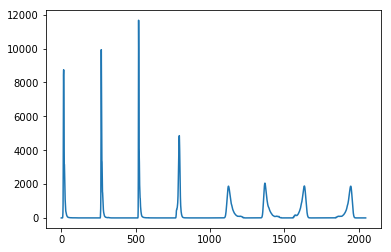

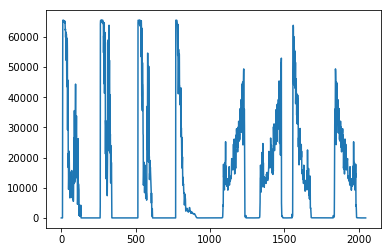

In [42]:
print (trOX.max(), trOX.min(), trOX.mean())
#print (trOX.max(axis=0), trOX.min(axis=0), trOX[:].mean(axis=0))

trOX.shape, 512/64
plt.plot(trOX.mean(axis=0)); plt.show()
plt.plot(trOX.max(axis=0)); plt.show()
#plt.plot(trOX[0:10000].min(axis=0)); plt.show()

In [43]:
dirIn    = tDirs[1]
for bds in binsList :
    print ('-------->: bins={} Ext={} input-dir={}'.format(bds,ttExt,dirIn))
    trOX, trOY = generateTest(dirIn,bds,debugOK=debug)
    np.save('../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-XX.npy',trOX)
    np.save('../Data-XGB/Datas/test-'+str(10000+bds)+ttExt+'-YY.npy',trOY)
    #print (bds,trOX.shape,trOY.shape, (trOX.shape[1]/bds)*bds, trOX.shape[1]/3)

-------->: bins=64 Ext=.tif input-dir=../Data/test-tif-v2
2017-07-09 06:54:21.889978 61191 61191
2017-07-09 06:57:31.725410 	 5000 	 test_15645.tif
2017-07-09 07:00:37.807045 	 10000 	 test_2615.tif
2017-07-09 07:03:45.032377 	 15000 	 test_6054.tif
2017-07-09 07:06:50.669121 	 20000 	 test_22406.tif
2017-07-09 07:09:59.022370 	 25000 	 test_37025.tif
2017-07-09 07:13:05.107455 	 30000 	 test_8910.tif
2017-07-09 07:16:07.391564 	 35000 	 test_39596.tif
2017-07-09 07:19:12.409705 	 40000 	 test_7740.tif
2017-07-09 07:22:18.623749 	 45000 	 test_35456.tif
2017-07-09 07:25:20.937514 	 50000 	 file_17548.tif
2017-07-09 07:28:31.253600 	 55000 	 test_19494.tif
2017-07-09 07:31:37.651248 	 60000 	 test_2939.tif
2017-07-09 07:32:19.848765
-------->: bins=128 Ext=.tif input-dir=../Data/test-tif-v2
2017-07-09 07:32:21.123499 61191 61191
2017-07-09 07:35:32.577261 	 5000 	 test_15645.tif
2017-07-09 07:39:04.115195 	 10000 	 test_2615.tif
2017-07-09 07:42:10.948499 	 15000 	 test_6054.tif
2017-07

65535 0 255.973329411


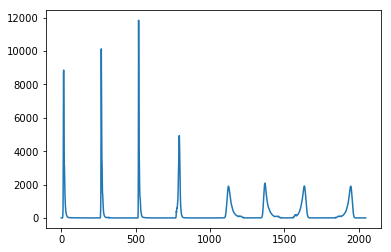

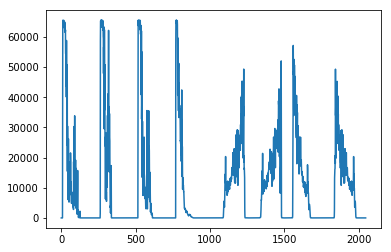

In [44]:
print (trOX.max(), trOX.min(), trOX.mean())
#print (trOX.max(axis=1), trOX.min(), trOX[:].mean())

trOX.shape, 512/64
plt.plot(trOX[0:10000].mean(axis=0)); plt.show()
plt.plot(trOX[0:10000].max(axis=0)); plt.show()
#plt.plot(trOX[0:10000].min(axis=0)); plt.show()

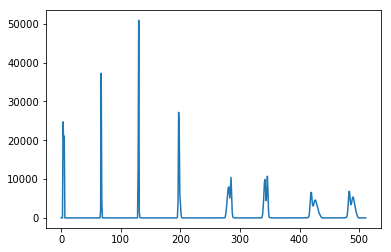

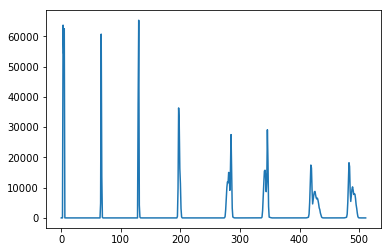

In [32]:
plt.plot(trOX[0:10000].mean(axis=0)); plt.show()
plt.plot(trOX[0:10000].max(axis=0)); plt.show()

In [25]:
ax  = trOX
ax2 = np.zeros((ax.shape[0],(ax.shape[1]/2)))
for i in range(ax2.shape[1]) :
    ax2[:,i] = ax[:,2*i]+ax[:,2*i+1]
trOX.shape, ax2.shape

((61191, 384), (61191, 192))

In [153]:
##--------------------- Examples save/load procedure

In [154]:
if False :
    trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
    trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
    print(trX.shape,trY.shape)

In [155]:
if False :
    np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
    np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)